In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import xarray as xr
from sklearn import linear_model
from sklearn.pipeline import make_pipeline
from sklearn.preprocessing import PolynomialFeatures
from sklearn.model_selection import validation_curve
from sklearn.metrics import make_scorer

In [2]:
plt.style.use('default')
plt.rcParams['figure.figsize'] = (12,10)

## Data pre-processing

In [3]:
#netcdf path
nc_path = '../../hydropt_4_sent3/data/interim/D20200125_125223_PACE_FF0014/*.nc'

In [4]:
ds = xr.open_mfdataset(nc_path, combine='by_coords')

In [5]:
# subset dataset for just above (Ed) and below (IOPs) sea-surface parameter values
ds = ds.isel(geom_depth=0, geom_depth_air=0, suntheta=0)

In [19]:
# calculate rrs
ds['rrs'] = ds.RADMa/ds.Ed

In [20]:
# subset for NADIR viewing angles
ds_nadir = ds.isel(phi=0, fmu=9)

In [21]:
# select total absorption, total backscatter coefficients and Rrs
var = ['acoef', 'bbcoef', 'rrs']
ds_nadir = ds_nadir[var]

In [22]:
ds_df = ds_nadir.to_dataframe()

In [23]:
wbands = ds_df.index.get_level_values('wavelength').unique()

## Model cross-validation

In [24]:
# make pipeline for polynomial regressor with n degrees
def PolynomialRegression(degree, **kwargs):
    return make_pipeline(PolynomialFeatures(degree),
                         linear_model.LinearRegression(**kwargs))

In [25]:
model = make_pipeline(PolynomialFeatures(), linear_model.LinearRegression())

In [26]:
def exp_rmsre(y, yhat):
    n = len(y)
    fdiff = ((np.exp(y)-np.exp(yhat))/np.exp(y))**2
    loss = np.sqrt(np.sum(fdiff)/n)
    
    return loss

In [27]:
exp_root_mean_squared_relative_error = make_scorer(exp_rmsre, greater_is_better=True)

In [28]:
train_scores = {}
val_scores = {}

for idx, data in ds_df.groupby('wavelength'):
    # log transform independent variables
    X = np.log(data[['acoef', 'bbcoef']])
    # dependent variable (i.e. Rrs)
    Y = np.log(data[['rrs']])
    
    degree = np.arange(1, 10)
    train_score, val_score = validation_curve(model, X, Y, param_name='polynomialfeatures__degree', param_range=degree, cv=10,
                                          scoring=exp_root_mean_squared_relative_error)
    
    train_scores[idx] = {'mean': (np.mean(train_score, 1)),
                         'std': np.std(train_score,1)}
    val_scores[idx] = {'mean': (np.mean(val_score, 1)),
                       'std': np.std(val_score,1)}

In [29]:
# calculate validation score for every polynomial degree averaged over all wavebands
val_scores_mean = np.array([val_scores[i]['mean'] for i in wbands]).mean(axis=0)
# with standard dev
val_scores_std = np.array([val_scores[i]['mean'] for i in wbands]).std(axis=0)

In [30]:
# calculate train score for every polynomial degree averaged over all wavebands
train_scores_mean = np.array([train_scores[i]['mean'] for i in wbands]).mean(axis=0)
# with standard dev
train_scores_std = np.array([train_scores[i]['mean'] for i in wbands]).std(axis=0)

(-0.025, 0.1)

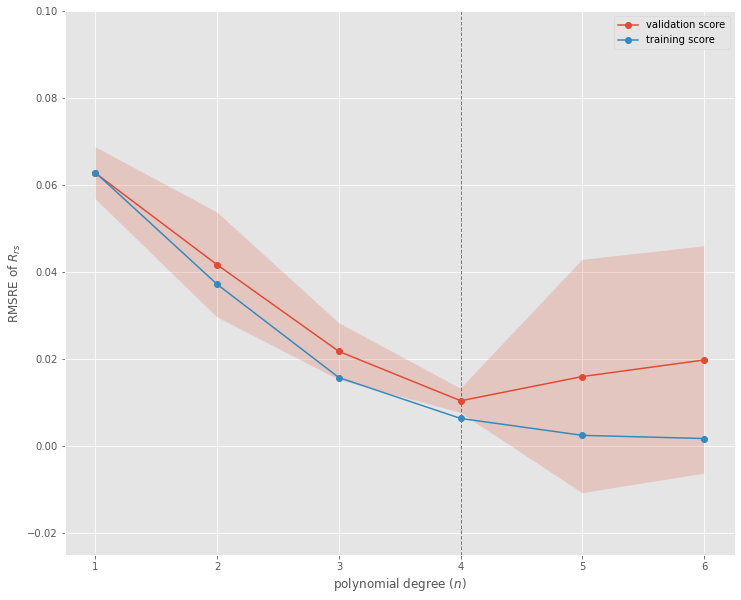

In [31]:
degree_range = slice(0,6)
plt.axvline(4, linestyle='dashed', linewidth=1, color='black', alpha=.5)
# validation curve
plt.plot(degree[degree_range], val_scores_mean[degree_range], marker='o', label='validation score')
plt.fill_between(degree[degree_range],
                val_scores_mean[degree_range]-val_scores_std[degree_range],
                val_scores_mean[degree_range]+val_scores_std[degree_range],
                alpha=.2)

# training curve
plt.plot(degree[degree_range], train_scores_mean[degree_range], marker='o', label='training score')
# plt.fill_between(degree[degree_range],
#                 train_scores_mean[degree_range]-train_scores_std[degree_range],
#                 train_scores_mean[degree_range]+train_scores_std[degree_range],
#                 alpha=.2)


plt.legend(loc='best')
#plt.ylim(-.01, 0.001)
plt.xlabel('polynomial degree ($n$)')
plt.ylabel('RMSRE of $R_{rs}$')
plt.ylim(-.025, .1)

In [32]:
def calculate_error(x, degree):
    X = np.log(x[['acoef','bbcoef']])
    Y = np.log(x['rrs'])
    rrs_hat = PolynomialRegression(degree)\
                .fit(X,Y)\
                .predict(X)
    # relative error
    err = (np.exp(rrs_hat) - np.exp(Y))/np.exp(Y)*100
    
    return err

In [33]:
rrs_error = ds_df\
    .groupby('wavelength')\
    .apply(calculate_error, 4)

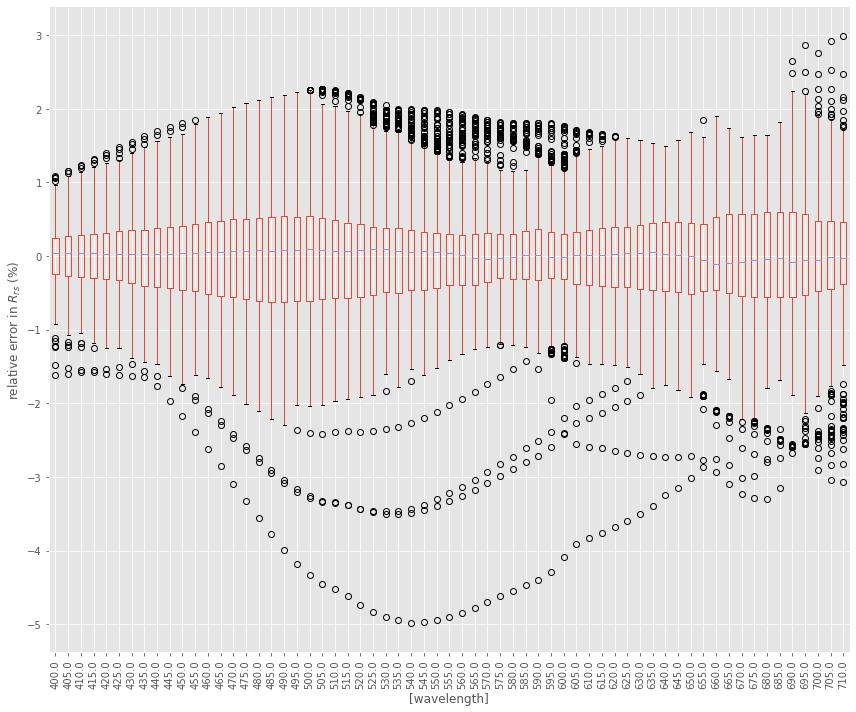

In [34]:
rrs_error.to_frame().boxplot(by='wavelength')
plt.xticks(rotation=90)
plt.ylabel('relative error in $R_{rs}$ (%)')
#plt.title('relative error per waveband')
plt.title('')
plt.suptitle(' ')
plt.tight_layout()

### Viewing angle

In [58]:
# select data at waveband 440
ds_wb440 = ds.sel(wavelength=440)[var]

In [61]:
df_wb440 = ds_wb440.to_dataframe()

In [67]:
# remove last 23 entries in RADMa
# remove all phi entries for fmu==0.998.. except for phi==0 (which is NADIR)
idx = np.unique(df_wb440\
        .reset_index(['CDOM', 'Chl', 'NAP'])\
        .index)[-23:]

In [76]:
rrs_440_geom_error = df_wb440.reset_index(['CDOM', 'Chl', 'NAP'])\
       .drop(idx)\
       .reset_index()\
       .groupby(['fmu','phi'])\
       .apply(calculate_error, degree=4)\
       .abs()\
       .mean(level=['fmu','phi'])

Text(0.5, 1.0, 'mean relative error\n (%)')

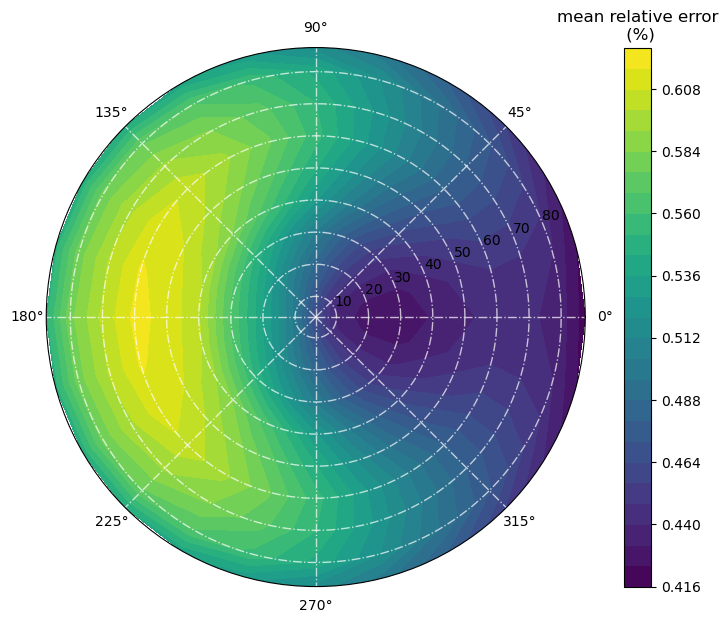

In [90]:
# get fmu and phi values
fmu = np.unique(ds.fmu)
phi = np.unique(ds.phi)
# calculate zeniths in degrees
zeniths = np.degrees(np.arccos(fmu))
values = rrs_440_geom_error.values
#values = rrs_442_geom_error.values
# get the 23 values of the polar cap and append to values
values = np.append(values, np.repeat(values[-1], 23))
# reshape
values = values.reshape(zeniths.size, phi.size)
# add 360 deg to azimuth angles
phi = np.append(phi, 2*np.pi)
# transpose
values = values.T
# 0 deg should be the same as 360 deg
values = np.vstack([values, values[0]])

r, theta = np.meshgrid(zeniths, phi)
fig = plt.figure(figsize=(10,7))
ax = fig.add_subplot(111, projection='polar')
cax = ax.contourf(theta, r, values, 30, cmap='viridis')
ax.grid(linewidth=1, linestyle='-.', color='w', alpha=.7)
#cax.set_clim(0,1)
fig.colorbar(cax).ax.set_title('mean relative error\n (%)')
#ax.set_title('CDOM: 0.005 $m^{-1}$, Chl: 31 $mg\ m^{-3}$, NAP: 100 $g\ m^{-3}$')